In [2]:
import h5py
import bokeh
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from lal import gpstime
import datetime
from aframe.analysis.ledger.events import EventSet, RecoveredInjectionSet
from aframe.analysis.ledger.injections import InjectionParameterSet

In [42]:
import bokeh
bokeh.__version__

'3.1.1'

In [403]:
basedir = Path("/home/ethan.marx/aframe/methods-paper-intervals/")
mass_combo = "35-35"
tmp = [
    x for x in basedir.iterdir() if x.is_dir() and x.name != "condor"
]
tmp.sort(key=lambda x: datetime.datetime.strptime(x.name.split("_")[0], "%m-%d-%Y"))
weeks = [1, 2, 4, 12, 24, 32, 40]
ifos = ["H1", "L1"]
intervals = [Path("/home/ethan.marx/aframe/methods-paper-data/")]
intervals.extend(tmp)


In [404]:
def load_sv(path: Path, combo: str = mass_combo):
    with h5py.File(path, "r") as f:
        idx = 5
        thresholds = f["thresholds"][:]
        fars = f["fars"][:]
        combo = f[combo]
        sv = combo["sv"][:]
        err = combo["err"][:]
    return sv[idx], err[idx], fars[idx]

In [405]:
def glitch_rate_vs_snr(datadir: Path):
    bins = np.linspace(5, 100, 100)
    cum = np.zeros(len(bins) - 1)
    for path in datadir.iterdir():
        if path.suffix != ".h5":
            continue
        with h5py.File(path) as f:
            snrs = f["triggers"]["snr"][:]
        hist, bins = np.histogram(snrs, bins=bins)
        hist = np.cumsum(hist[::-1])[::-1]
        cum += hist
    return cum, bins

In [355]:
def count_training_data(data_dir: Path):
    livetime = 0
    for f in data_dir.iterdir():
        livetime += float(f.name.split("-")[-1].split(".")[0]) / 86400
    return livetime

In [406]:
idx = 5
training_cum_glitch_rates = []
for interval in intervals:
    base = interval / "data" / "omicron" / "training"
    if interval.name == "methods-paper-data":
        base = interval / "train" / "omicron" / "training"
    rate = []
    for ifo in ifos:
        training_triggers = base / ifo / "merge" / f"{ifo}:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01"
        lt_dir = interval / "data" / "train" / "background"
        if interval.name == "methods-paper-data":
            lt_dir = interval / "train" / "background"
        livetime = count_training_data(lt_dir)
        cum_training, bins = glitch_rate_vs_snr(training_triggers)
        rate.append(cum_training[idx] / livetime)
    training_cum_glitch_rates.append(rate)
training_cum_glitch_rates = np.array(training_cum_glitch_rates)
print(bins[idx])

9.797979797979798


In [407]:
testing_cum_glitch_rates = []
for interval in intervals:
    base = interval / "data" / "omicron" / "testing"
    if interval.name == "methods-paper-data":
        base = interval / "train" / "omicron" / "testing"
    rate = []
    for ifo in ifos:
        training_triggers = base / ifo / "merge" / f"{ifo}:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01"
        lt_dir = interval / "data" / "test" / "background"
        if interval.name == "methods-paper-data":
            lt_dir = interval / "test" / "background"
        livetime = count_training_data(lt_dir)
        cum_training, bins = glitch_rate_vs_snr(training_triggers)
        rate.append(cum_training[0] / livetime)
    testing_cum_glitch_rates.append(rate)
testing_cum_glitch_rates = np.array(testing_cum_glitch_rates)

In [408]:
def load_valid_loss(path: Path):
    with h5py.File(path) as f:
        valid_loss = f['valid_auroc@1.0e-03'][:]
    return valid_loss


In [409]:
@dataclass
class IntervalResults:
    original: float
    retrained: float
    original_valid: float
    retrained_valid: float
    original_err: float
    retrained_err: float

results: list[IntervalResults] = []
for interval in intervals:
    if interval.name == "methods-paper-data":
        continue
    livetime = count_training_data(interval / "data" / "train" / "background")
    print(livetime)
    original_sv, original_err, far = load_sv(interval / "original" / "results" / "sensitive-volume.h5")
    retrained_sv, retrained_err, far = load_sv(interval / "retrained" / "results" / "sensitive-volume.h5")

    retrained_valid_arg = np.argmax(load_valid_loss(interval / "retrained" / "training" / "history.h5"))
    retrained_valid = load_valid_loss(interval / "retrained" / "training" / "history.h5")[retrained_valid_arg]
    original_valid = load_valid_loss(interval / "original" / "original-val-score" / "history.h5")[0]
    print(f"Appending interval {interval.name}")
    results.append(
        IntervalResults(
            original_sv,
            retrained_sv,
            original_valid,
            retrained_valid,
            original_err,
            retrained_err,
        )
    )


4.915844907407408
Appending interval 06-15-2019_06-22-2019
3.8783333333333334
Appending interval 06-22-2019_06-29-2019
4.522175925925926
Appending interval 07-06-2019_07-13-2019
4.1613541666666665
Appending interval 08-31-2019_09-07-2019
4.722175925925926
Appending interval 11-23-2019_11-30-2019
4.549675925925926
Appending interval 01-18-2020_01-25-2020
5.090659722222223
Appending interval 03-14-2020_03-21-2020


In [397]:
1256655618

0.4771891789989631

In [410]:
original_svs = np.array([x.original for x in results])
retrained_svs = np.array([x.retrained for x in results])
original_valids = np.array([x.original_valid for x in results])
retrained_valids = np.array([x.retrained_valid for x in results])
original_errors = np.array([x.original_err for x in results])
retrained_errors = np.array([x.retrained_err for x in results])


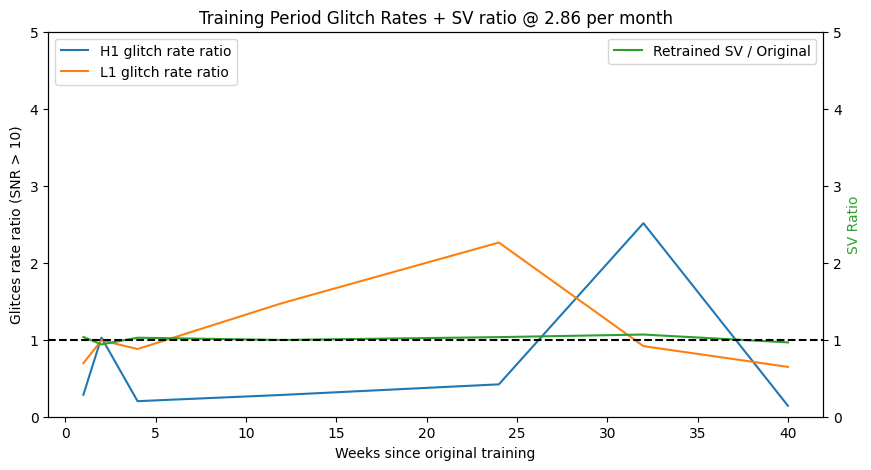

In [411]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(weeks, training_cum_glitch_rates[1:, 0] / training_cum_glitch_rates[0, 0], label = "H1 glitch rate ratio")
ax1.plot(weeks, training_cum_glitch_rates[1:, 1] / training_cum_glitch_rates[0, 1], label = "L1 glitch rate ratio")
ax2.plot(weeks, retrained_svs / original_svs, label = "Retrained SV / Original", color="C2")
ax2.legend()
ax1.set_xlabel("Weeks since original training")
ax1.set_ylim([0, 5])
ax2.set_ylim([0, 5])
plt.axhline(1, color="k", linestyle="--")
ax1.set_ylabel("Glitces rate ratio (SNR > 10)")
ax2.set_ylabel("SV Ratio", color="C2")
ax1.set_title(f"Training Period Glitch Rates + SV ratio @ {far:.2f} per month")
ax1.legend(loc="upper left")

NameError: name 'ret' is not defined

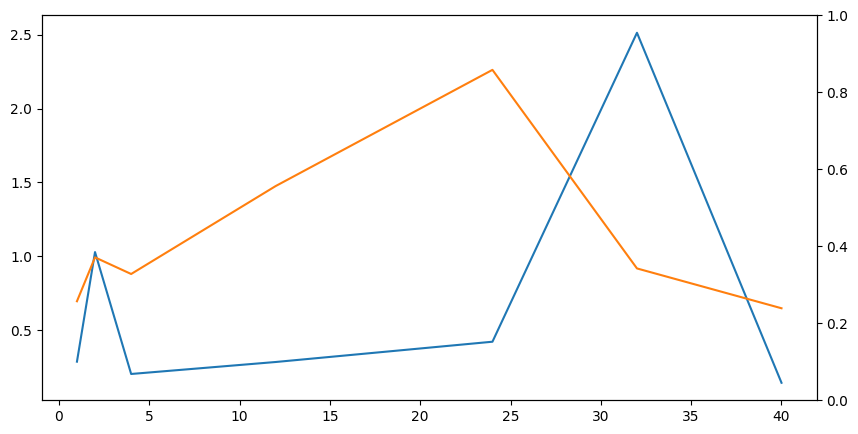

In [412]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

ax1.plot(weeks, training_cum_glitch_rates[1:, 0] / training_cum_glitch_rates[0, 0], label = "H1 glitch rate ratio")
ax1.plot(weeks, training_cum_glitch_rates[1:, 1] / training_cum_glitch_rates[0, 1], label = "L1 glitch rate ratio")
ax2.plot(weeks,  original_svs / ret, label = "Retrained SV / Original", color="C2")
ax2.legend()
ax1.set_xlabel("Weeks since original training")
ax1.set_ylabel("Glitces rate ratio (SNR > 5)")
ax2.set_ylabel("SV Ratio", color="C2")
ax1.set_title(f"Training Period Glitch Rates + SV ratio @ {far:.2f} per month")
ax1.legend()

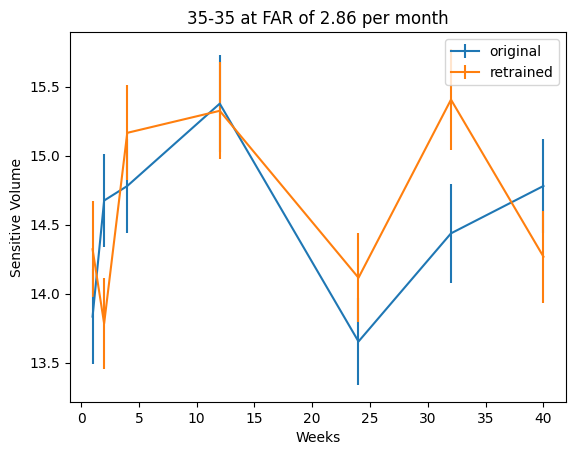

In [413]:
plt.figure()
#plt.errorbar(weeks, original_svs / retrained_svs, )
plt.errorbar(weeks, original_svs, yerr=original_errors, label="original")
plt.errorbar(weeks, retrained_svs, yerr=retrained_errors, label="retrained")
plt.xlabel("Weeks")
plt.ylabel("Sensitive Volume")
plt.title(f"{mass_combo} at FAR of {far:.2f} per month")
plt.legend()
plt.savefig("sv-over-time.png")

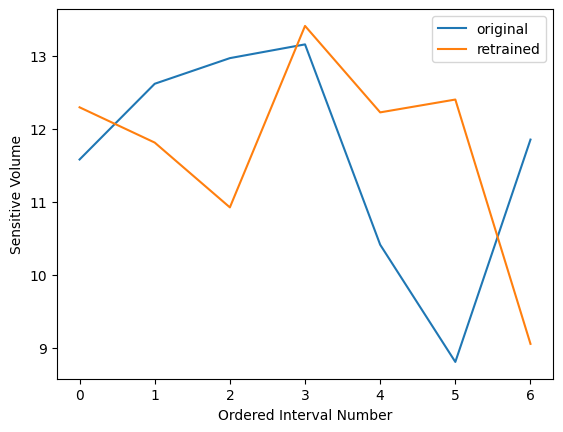

In [144]:
plt.plot(original_svs, label="original")
plt.plot(retrained_svs, label="retrained")
plt.xlabel("Ordered Interval Number")
plt.ylabel("Sensitive Volume")
plt.legend()


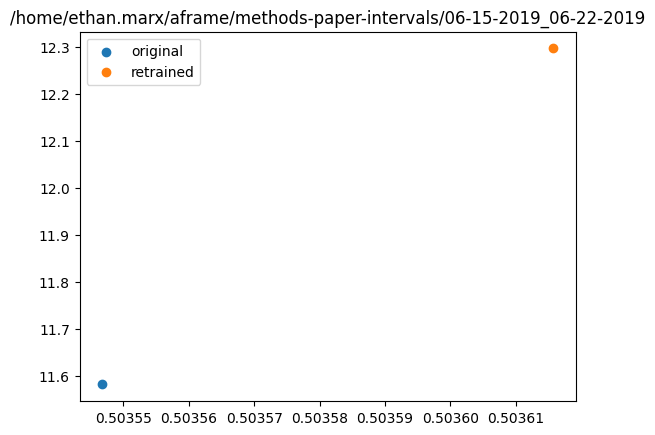

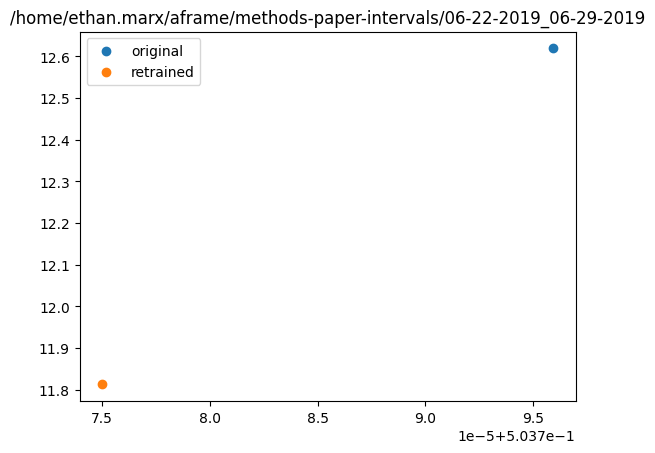

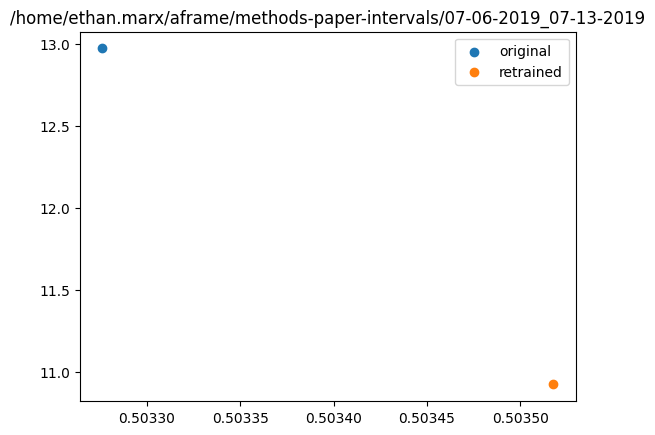

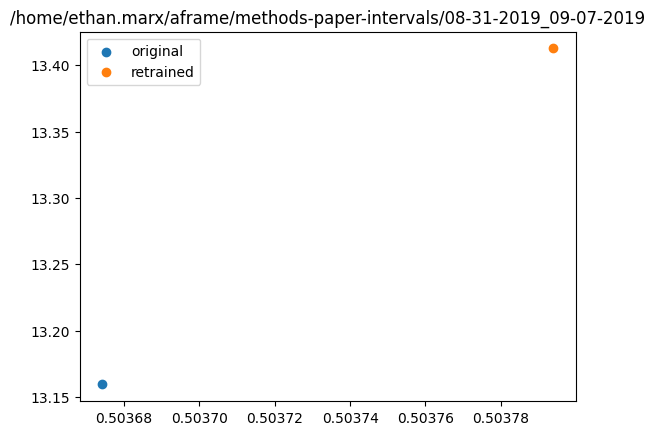

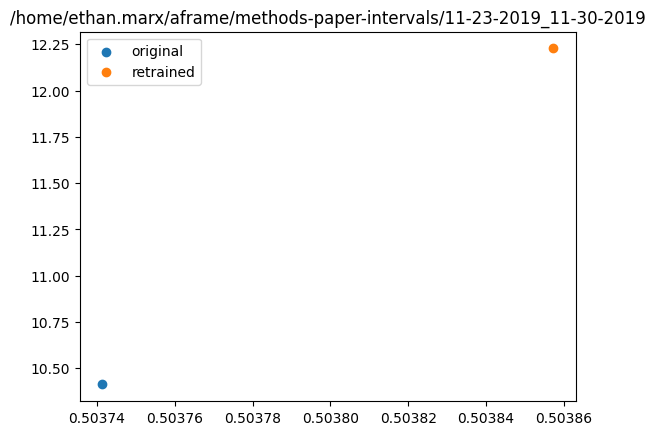

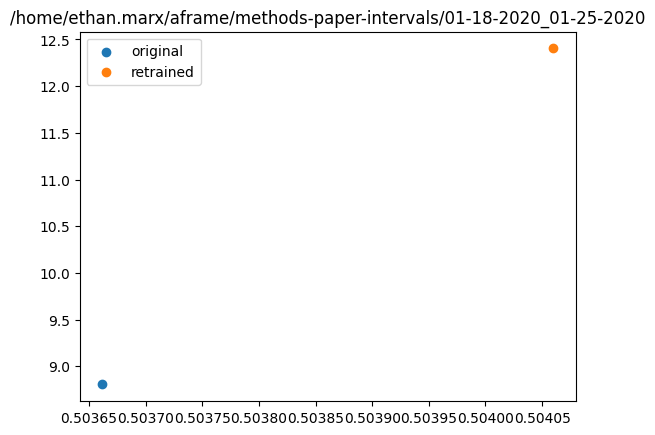

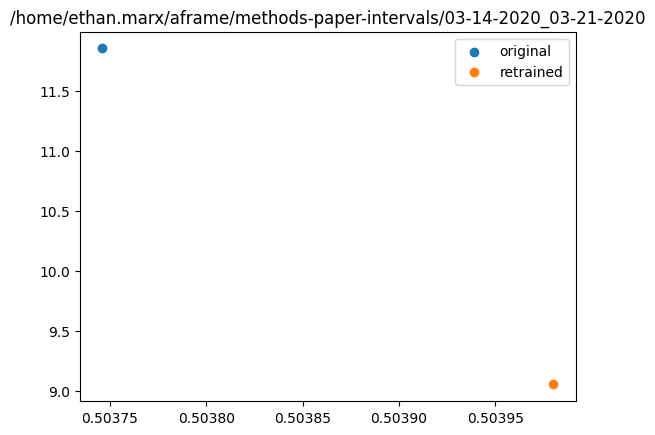

In [145]:
for i in range(len(original_valids)):
    plt.figure()
    plt.scatter(original_valids[i], original_svs[i], label="original")
    plt.scatter(retrained_valids[i], retrained_svs[i], label="retrained")
    plt.title(intervals[i])
    plt.legend()


In [172]:
args = background.detection_statistic.argsort()[::-1]

In [173]:
background.detection_statistic[args]

array([ 7.51447463,  7.46888626,  6.3225323 , ..., -2.82074934,
       -2.82269198, -2.86970752])

In [176]:
background.time[args][1]

1268319977.0

In [164]:
def omicron_triggers_from_time(datadir: Path, time: float, delta: float = 1):
    for path in datadir.iterdir():
        if path.suffix != ".h5":
            continue
        start = float(path.name.split("-")[-2])
        stop = float(path.name.split("-")[-1].split(".")[0]) + start
        if time >= start and time <= stop:
            print(path)
            with h5py.File(path) as f:
                triggers = f["triggers"][:]
                print(np.min(np.abs(triggers["time"] - time)))
            return triggers[np.abs(triggers["time"] - time) < delta]

In [177]:
datadir = Path("/home/ethan.marx/aframe/methods-paper-intervals/03-14-2020_03-21-2020/") / "data" / "omicron" / "testing" / "H1" / "merge" / "H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01"
omicron_triggers_from_time(datadir, 1268319977.0)

/home/ethan.marx/aframe/methods-paper-intervals/03-14-2020_03-21-2020/data/omicron/testing/H1/merge/H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01/H1-DCS_CALIB_STRAIN_CLEAN_SUB60HZ_C01_OMICRON-1268300022-29987.h5
0.015625


array([(1.26831998e+09, 58.82107779, 1.26831998e+09, 1.26831998e+09, 56.48165901, 82.68564972, 6.41161346, 37.98442282, 4.38644854e-23, -1.01435213),
       (1.26831998e+09, 54.01416373, 1.26831998e+09, 1.26831998e+09, 48.64476626, 59.97623399, 5.51955396,  4.69860659, 4.08104942e-23, -1.49645954)],
      dtype={'names': ['time', 'frequency', 'tstart', 'tend', 'fstart', 'fend', 'snr', 'q', 'amplitude', 'phase'], 'formats': ['<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8'], 'offsets': [0, 8, 48, 56, 64, 72, 16, 24, 32, 40], 'itemsize': 80})

In [137]:
path = Path("/home/ethan.marx/aframe/methods-paper-intervals/03-14-2020_03-21-2020/original/")
background_file = path / "infer" / "background.h5"
foreground_file = path / "infer" / "foreground.h5"
background = EventSet.read(background_file)
foreground = RecoveredInjectionSet.read(foreground_file)


In [139]:
path = Path("/home/ethan.marx/aframe/methods-paper-intervals/03-14-2020_03-21-2020/retrained/")
background_file = path / "infer" / "background.h5"
foreground_file = path / "infer" / "foreground.h5"
background_retrained = EventSet.read(background_file)
foreground_retrained = RecoveredInjectionSet.read(foreground_file)

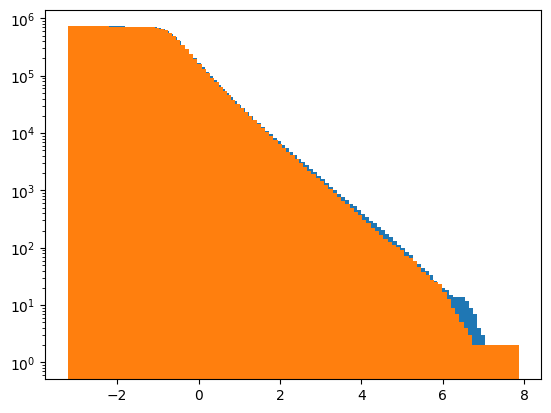

In [184]:
hist, bins = np.histogram(np.sort(background_retrained.detection_statistic)[:-1], bins=100)
hist = np.cumsum(hist[::-1])[::-1]
plt.bar((bins[:-1] + bins[1:]) / 2, hist)

hist, bins = np.histogram(background.detection_statistic, bins=100)
hist = np.cumsum(hist[::-1])[::-1]
plt.bar((bins[:-1] + bins[1:]) / 2, hist)


plt.yscale("log")

In [177]:
background_retrained.time[background_retrained.detection_statistic.argsort()[-2]]

1268797991.75

In [166]:

background_retrained.shift[background_retrained.detection_statistic.argmax()]

array([0., 4.])

In [178]:
background_retrained.time[background_retrained.detection_statistic.argsort()[-2]]

1268797991.75

In [179]:
background_retrained.detection_statistic[background_retrained.detection_statistic.argsort()[-2]]

7.277500748634338

NameError: name 'Path' is not defined

## Dev for paper plot

In [1]:
import numpy as np

from bokeh.models import Span, Label
from bokeh.plotting import figure, save
from bokeh.palettes import Bright7 as palette  # noqa
from bokeh.models import Legend, LegendItem
from typing import List
import numpy as np
from bokeh.io import output_notebook, show, export_svg
from bokeh.models import Legend, LegendItem
from bokeh.palettes import RdYlBu4 as palette
from pathlib import Path
import datetime
import h5py
output_notebook()


Loading BokehJS ...

In [2]:
basedir = Path("/home/ethan.marx/aframe/methods-paper-intervals/")
mass_combo = "35-35"

In [3]:
def get_figure(**kwargs):
    default_kwargs = dict(
        height=500,
        width=1100,
        tools=""
    )
    kwargs = default_kwargs | kwargs
    p = figure(**kwargs)

    if not kwargs.get("tools"):
        p.toolbar_location = None

    title = kwargs.get("title")
    if title and title.startswith("$$"):
        p.title.text_font_style = "normal"
    return p

In [4]:
def load_sv(path: Path, combo: str):
    with h5py.File(path, "r") as f:
        fars = f["fars"][:]
        combo = f[combo]
        sv = combo["sv"][:]
    return sv, fars

def calc_sd_over_time(intervals: List[Path], name: str, mass_combo: str, fars: np.ndarray):
    data = []
    for interval in intervals:
        path = interval / name / "results" / "sensitive-volume.h5"
        sv, far = load_sv(path, mass_combo)
        interped = np.interp(fars, far, sv)
        data.append(interped)
    return data

In [7]:
def main(
    basedir: Path,
    original_path: Path,
    mass_combo: str,
    weeks: List[int],
):
    fars = np.array([0.5, 1, 2, 5])
    intervals = [
        x for x in basedir.iterdir() if x.is_dir() and x.name != "condor"
    ]
    intervals.sort(key=lambda x: datetime.datetime.strptime(x.name.split("_")[0], "%m-%d-%Y"))

    # load in results for intervals 
    original = calc_sd_over_time(intervals, "original", mass_combo, fars)

    # load in results for original model
    weeks.insert(0, 0)
    sv, far = load_sv(original_path, mass_combo)
    interped = np.interp(fars, far, sv)
    original.insert(0, interped)
    original = np.array(original)

    p = get_figure(
        title="Sensitive Distance Over Time for 35/35 Lognormal",
        x_axis_label="Weeks After Original Test Period",
        y_axis_label="Sensitive Distance (Mpc)",
        tools="save"
    )


    o3b_start = 1256655618
    o3a_end = 1253977218
    original_start = 1244035783
    ONE_WEEK = 60 * 60 * 24 * 7
    break_weeks = []
    for time in [o3a_end, o3b_start]:
        diff = time - original_start
        break_weeks.append(diff / ONE_WEEK)
    mid = np.mean(break_weeks)

    # add a line representing O3a / O3b divide,
    # and add text labels
    run_break = Span(location=mid, dimension='height',
        line_color="black", line_width=2)
    p.add_layout(run_break)
    p.add_layout(Label(x=mid - 3.5, y=15, text='O3a', text_font_size="20pt"))
    p.add_layout(Label(x=mid + 1, y=15, text='O3b', text_font_size="20pt"))

    legends = []
    for i, far in enumerate(fars):
        
        c = p.circle(
            x=weeks,
            y=original[:, i],
            size=10,
            color=palette[i]
        )
        
        legends.append(LegendItem(renderers=[c], label=f"FAR {far}/month"))

    legend = Legend(items=legends, click_policy="mute")
    p.add_layout(legend, "right")
    p.output_backend = "svg"
    export_svg(p, filename="senstive-distance-over-time.svg")

    return p

In [8]:
p = main(
    basedir = Path("/home/ethan.marx/aframe/methods-paper-intervals/"),
    original_path = Path("/home/ethan.marx/aframe/methods-paper-main-run/infer/sensitive-volume.h5"),
    mass_combo = "35-35",
    weeks = [1, 2, 4, 12, 24, 32, 40]
)

In [80]:
show(p)

In [32]:
1253977218 - 1238166018

15811200

In [36]:
15811200 / ONE_WEEK 

26.142857142857142

In [35]:

ONE_WEEK = 60 * 60 * 24 * 7